# Lie Groups and Learning Rotations
`Drew Wilimitis`

![title](images/q4.gif)

**Note:** I occasionally use the `geomstats` library for visualization (https://github.com/geomstats/geomstats)

The group theoretic approach to machine learning used here is somewhat of an extension of the more traditional methods of Manifold Learning. Riemannian, and often non-Euclidean, geometries provide the background setting in which Lie Groups can be incorporated to learn from sets of training images and predict rotational trajectories. <br>

There are a few Python libraries that have implemented classes of Lie Groups, such as `geomstats`, `theano`, and `PyGeometry`, however; I will attempt to implement the algorithm outlined primarily in **[3]**

## Mathematical Background

**Definition**: A **group** $G = (X, *)$ is just a set endowed with the operation $*$ that satisfies a few basic axioms <br>

1. For any $x, y \in G, x y$ is also an element of $G$ (closure).
2. For any $x, y, z \in G, \quad(x y) z=x(y z)$ (associativity).
3. There is a unique element of $G,$ denoted $e,$ and called the identity element, for which
$$
e x=x e=x \text { for any } x \in G
$$
4. For any $x \in G$ there is a corresponding element $x^{-1} \in G,$ called the inverse of $x,$ which
$$
\text { satisfies } x x^{-1}=x^{-1} x=e
$$

**Definition**: A **Lie group** $G$ is a **topological group** that is also a differentiable manifold. As opposed to discrete groups, a Lie group is therefore continuous and can be considered to represent continuous symmetries such as rotating a unit circle in a Euclidean plane or the group of rotations in $\mathbb{R^3}$<br>

There are a few classic examples of Lie groups sometimes called *matrix groups*, and the one we focus on is called the **Special Orthogonal Group** - $\mathrm{SO}(\mathrm{n})$

The special orthogonal group is the set of $N x N$ orthogonal matrices, denoted $\mathrm{SO}(\mathrm{n})$, which is the Lie group of rotation matrices in $\mathbb{R^n}$ with unit determinant. The operation $*$ between group elements is composition, for which the rotation group is closed and invertible. <br>

$$
S O(n)=\left\{R \in \mathbb{R}_{n \times n}: R^{T} . R=I d_{n} \text { and } \operatorname{det} R=1\right\}
$$ 

For $\mathrm{SO}(\mathrm{3})$, rotation matrices are in $\mathbb{R^{3 x 3}}$, and the Lie group is of dimension $n(n-1) / 2$

We can imagine the standard basis for this group of rotation matrices is given by the following rotation matrices:

$$
L_{\mathbf{x}}=\left[\begin{array}{ccc}
{0} & {0} & {0} \\
{0} & {0} & {-1} \\
{0} & {1} & {0}
\end{array}\right], \quad L_{\mathbf{y}}=\left[\begin{array}{ccc}
{0} & {0} & {1} \\
{0} & {0} & {0} \\
{-1} & {0} & {0}
\end{array}\right], \quad L_{\mathbf{z}}=\left[\begin{array}{ccc}
{0} & {-1} & {0} \\
{1} & {0} & {0} \\
{0} & {0} & {0}
\end{array}\right]
$$

### Import libraries and load data

In [59]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os
import geomstats

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

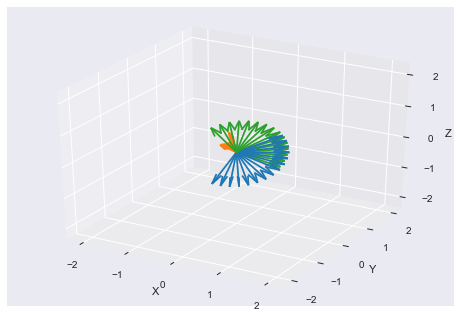

In [294]:
from geomstats.special_orthogonal_group import SpecialOrthogonalGroup
from geomstats.visualization import plot
os.environ['GEOMSTATS_BACKEND'] = 'numpy'
SO3_GROUP = SpecialOrthogonalGroup(n=3)
METRIC = SO3_GROUP.left_canonical_metric

pts = SO3_GROUP.random_uniform(n_samples=2)
geodesic = METRIC.geodesic(initial_point=pts[0],end_point=pts[1])
n_steps = 15
t = np.linspace(-1, 1, n_steps)

points = geodesic(t)
plot(points, space='SO3_GROUP')
plt.show();

$$
\theta=\arccos \left(\frac{\operatorname{Tr}(R)-1}{2}\right)
$$

$$
\omega=\frac{1}{2 \sin \theta}\left[\begin{array}{c}
{R(3,2)-R(2,3)} \\
{R(1,3)-R(3,1)} \\
{R(2,1)-R(1,2)}
\end{array}\right]
$$

$$
\begin{array}{l}
{t=Q_{x x}+Q_{y y}+Q_{z z}} \\
{r=\sqrt{1+Q_{x x}-Q_{y y}-Q_{z z}}} \\
{s=\frac{1}{2 r}} \\
{w=\left(Q_{z y}-Q_{y z}\right) s} \\
{x=\frac{1}{2} r} \\
{y=\left(Q_{x y}+Q_{y x}\right) s} \\
{z=\left(Q_{z x}+Q_{x z}\right) s}
\end{array}
$$

In [61]:
class SO_GROUP():
    """ Special Orthogonal Group SO(N) """

    def __init__(self, N = 3):
        """
        Initialize instance, set hardcode rotation window for now
        Parameters
        ----------
        N : dimension of Euclidean rotational space, default to 3
        """
        self.N = N
        self.dim = int(N * (N-1) / 2)  # dimension of Lie group
        self.rotation_window = np.round(2*np.pi, 3) # maximum radius of rotation arc
        self.identity = np.eye(N) # set identity element of the group
        self.default_axis = np.array([0, 0, 1]) # used in axis-angle form with small rotation angles
        
    def normalize(self, v):
        """
        Divide a vector by given norm to standardize unit length for axis-angle format
        Parameters
        ----------
        v : axis-vector shape (N, 1)
        """
        if np.linalg.norm(v) > 1:
            return v / np.linalg.norm(v)
        else:
            return v
        
    def validate(self, G, format_type = 'matrix'):
        """
        Checks on rotation matrix elements contained within SO(N)
        Parameters
        ----------
        G : array, shape (n_samples, N, N)
        """
        # first check
        if G.shape[0] == 0:
            print('Given empty input')
            return False
        
        # convert to (n_samples, N, N)
        if format_type != 'matrix':
            G = self.axis_angle_to_matrix
            
        # check square N x N matrices
        if G.shape[1] != self.N or G.shape[2] != self.N:
            print('Given wrong input matrix dimensions: {} x {}'.format(G.shape[1], G.shape[2]))
            return False
        
        # check orthogonality condition (R * R^T = 1 or det(R) = 1)
        if (np.allclose(np.matmul(g, g.T), np.eye(self.N)) for g in G).all():
            return True
        
    def rotation_matrix_to_axis_angle(self, R):
        """
        Convert from (N, N) rotation matrix to axis-angle representation
        Parameters
        ----------
        R : array, shape (N, N)
        
        Returns
        ----------
        theta (angle) = arccos(Tr(R) - 1) / 2
        omega (normalized axis) = 1/(2*sin(theta)) [R(3,2)-R(2,3)} \\
                                                   {R(1,3)-R(3,1)} \\
                                                   {R(2,1)-R(1,2)}]
        """
        APPROX = True
        np.testing.assert_array_equal(R.shape, (self.N, self.N))
        theta = np.arccos((np.matrix.trace(R) - 1) / 2)
        if theta == 0:
            return (self.default_axis, theta)
        else:
            axis = np.zeros((3, 1))
            axis[0, 0] = R[2, 1] - R[1, 2]
            axis[1, 0] = R[0, 2] - R[2, 0]
            axis[2, 0] = R[1, 0] - R[0, 1]
            if APPROX:
                return (axis * np.sign(theta)) / np.linalg.norm(axis)
            else:
                omega = (1 / (2*np.sin(theta))) * axis * np.sign(theta)
                return normalize(omega), theta % np.pi
            
    def rotation_matrix_to_quaternion(self, R):
        """
        Convert from (N, N) rotation matrix to unit quaternion q = w + xi + yj + zk representation
        Parameters
        ----------
        R : array, shape (N, N)
        
        Returns
        ----------
        Q : 4x1 vector representing quaternion components 

        """
        Q = np.zeros((4, 1))
        eps = 1e-6
        max_index = np.argmax(R.diagonal())
        if max_index == 0:
            tr_Q = R[0, 0] - R[1, 1] - R[2, 2]
        elif max_index == 1:
            tr_Q = R[1, 1] - R[2, 2] - R[0, 0]
        else:
            tr_Q = R[2, 2] - R[0, 0] - R[1, 1]
        r = 1 + tr_Q
        if np.abs(r - 0) < eps:
            return quaternion_from_axis_angle(self.default_axis, 0)
        else:
            u = max_index
            v = (max_index + 1) % 3
            w = (max_index + 2) % 3
            s = 1 / (2 * r)

            Q[0] = R[w, v] - R[v, w] # w
            Q[u + 1] = r / 2 # x
            Q[v + 1] = (R[u, v] + R[v, u]) * s # y
            Q[w + 1] = (R[w, u] + R[u, w]) * s # z
            if Q[0] < 0:
                Q = -Q
            return Q
        
    def quaternion_to_rotation_matrix(self, Q):
        """
        Convert from unit quaternion q = w + xi + yj + zk to orthogonal matrix R
        Parameters
        ----------
        Q : array, shape (4, 1)
        
        Returns
        ----------
        R : rotation matrix, shape (N, N)
        """
        a, b, c, d = Q
        R = np.zeros((self.N, self.N))
        R[0] = [a**2 + b**2 - c**2 - d**2, 2*b*c - 2*a*d, 2*b*d + 2*a*c]
        R[1] = [2*b*c + 2*a*d, a**2 - b**2 + c**2 - d**2, 2*c*d + 2*a*b]
        R[2] = [2*b*d - 2*a*c, 2*c*d + 2*a*b, a**2 - b**2 - c**2 + d**2]
        return R

In [62]:
SO3 = SO_GROUP(N=3)
SO3.dim

3

### Lie Algebra and the Matrix Exponential

![title](images/lie1.jpg)

**Definition**: The **Lie algebra** for this rotation group is the vector space tangent to the identity element of the group. The Lie Algebra is the space of skew symmetric $n \ x \ n$ matrices where $\mathbf{A}^{T}=-\mathbf{A}$. <br>

The matrix exponential and logarithm functions map elements between the Lie Group and the Lie Algebra. Given a Lie algebra element $\mathbf{A} \in \mathfrak{g}$, we have the corresponding group element given by the matrix exponential function $\exp (\mathbf{A})$: 


$$
\exp : \operatorname{so}(3) \rightarrow S O(3) ; \quad A \mapsto e^{A}=\sum_{k=0}^{\infty} \frac{1}{k !} A^{k}=I+A+\frac{1}{2} A^{2}+\cdots
$$ 

The matrix logarithm $\log (\mathbf{R}): \operatorname{S O(3) \rightarrow so}(3)$ is the inverse that maps elements from the Lie group to elements in the Lie Algebra

### Learning Rotations over $SO(N)$

We start from a series of $n$-dimensional unit vectors $x_t$ and we consider a rotation matrix $\mathbf{R}_{*}$ that gives instances of a rotated vector $y_{t}$ by the following:  $\mathbf{y}_{t}=\mathbf{R}_{*} \mathbf{x}_{t}$. <br>

We learn the rotation matrix by optimizing over the space of matrices in $SO(N)$, and this gives predictions for the rotated vector $y_t$ which we can use to define a loss function <br>

$$L_{t}\left(\hat{\mathbf{R}}_{t}\right)=d\left(\hat{\mathbf{y}}_{t}, \mathbf{y}_{t}\right)$$

The estimates of $\mathbf{R}_*$ are updated based on the following rule:

$$
\begin{aligned}
\hat{\mathbf{R}}_{t+1}=\underset{\mathbf{R}}{\arg \min } & \Delta_{F}\left(\mathbf{R}, \hat{\mathbf{R}}_{t}\right)+\eta L_{t}(\mathbf{R}) \\
\text { s.t. } & \mathbf{R}^{T} \mathbf{R}=\mathbf{I}, \mathbf{R} \mathbf{R}^{T}=\mathbf{I} \\
& \operatorname{det}(\mathbf{R})=1
\end{aligned}
$$

Note: updates include the von-Neumann divergence 

$$
\Delta_{F}\left(\mathbf{R}, \hat{\mathbf{R}}_{t}\right)=\operatorname{tr}\left(\mathbf{R} \log \mathbf{R}-\mathbf{R} \log \hat{\mathbf{R}}_{t}-\mathbf{R}+\hat{\mathbf{R}}_{t}\right)
$$

### Riemannian Gradient and Loss Function

Given loss function $L_{t}: \mathbf{S} \mathbf{O}(n) \rightarrow \mathbb{R}$, we have the gradient evaluated at rotation matrix $R$ and translated to the identity in order to obtain the Lie Algebra element:

$$
\tilde{\nabla}_{\mathbf{R}} L_{t}=\nabla_{\mathbf{R}} L_{t} \mathbf{R}^{T}-\mathbf{R} \nabla_{\mathbf{R}}^{T} L_{t}
$$ <br>

Using the squared error loss and applying Lagrangian multipliers for the constraints, we have the final update rule (aside from a complexity adjustment)

$$
\hat{\mathbf{R}}_{t+1}=\exp \left(\log \hat{\mathbf{R}}_{t}-\eta \operatorname{skew}\left(\hat{\mathbf{R}}_{t}^{T} \nabla_{\mathbf{R}} L_{t}\left(\hat{\mathbf{R}}_{t}\right)\right)\right)
$$<br>

The Riemannian gradient at the identity element is obtained by first rotating in the negative direction of $\hat{\mathbf{R}}_{t}$. The gradient corresponds to an element of the Lie Algebra, which is then mapped to the Lie Group by the exponential map.


\begin{textboxa}
\underline{Algorithm: Adaptive Rotation Learning with Riemannian gradient} <br>
    
Initialize $\mathbf{R}_{1}=\mathbf{I}$ <br>
**for** $t=1,2, \dots$ do: <br>
\begin{itemize}
\item Obtain an instance of unit vector $\mathbf{x}_{t} \in \mathbb{R}^{n}$
\item Predict the rotated vector $\hat{\mathbf{y}}_{t}=\hat{\mathbf{R}}_{t} \mathbf{x}_{t}$
\item Receive the true rotated vector $\mathbf{y}_{t}=\mathbf{R}_{*} \mathbf{x}_{t}$
\item Incur the $\operatorname{loss} L_{t}\left(\hat{\mathbf{R}}_{t}\right)=\left|\mathbf{y}_{t}-\hat{\mathbf{y}}_{t}\right|^{2}$
\item Compute the matrix $\mathbf{S}=2 \eta\left(\hat{\mathbf{R}}_{t}^{T} \mathbf{y}_{t} \mathbf{x}_{t}^{T}-\mathbf{x}_{t} \mathbf{y}_{t}^{T} \hat{\mathbf{R}}_{t}\right) $
\item Compute the eigenvalues $\lambda=2 \eta \sqrt{1-\left(\mathbf{y}_{t}^{T} \hat{\mathbf{y}}_{t}\right)^{2}}$
\item Update the rotation matrix $\hat{\mathbf{R}}_{t+1}=\hat{\mathbf{R}}_{t}\left(\mathbf{I}+\frac{\sin (\lambda)}{\lambda} \mathbf{S}+\frac{1-\cos (\lambda)}{\lambda^{2}} \mathbf{S}^{2}\right)$ 
\end{itemize}

**end** <br>

Note: $S$ is skew-symmetric with eigenvalues $\pm j \lambda$, and $\mathbf{y}_{t}, \hat{\mathbf{y}}_{t}$ are unit vectors in $\mathbb{R^N}$
\end{textboxa}

In [389]:
class LearnRotation():
    """ Execute training routine to learn optimal image poses & orientations """

    def __init__(self, N = 3, lr=0.1):
        """
        Initialize instance, set dimensions and format coincident with SO(N) class
        Parameters
        ----------
        N : dimension of Euclidean rotational space, default to 3
        """
        self.N = N
        self.group_dim = int(N * (N-1) / 2)  # dimension of Lie group
        self.R = np.eye(N) # set identity element of the group
        self.eta = lr # learning rate
        
    def loss_fn(self, y_true, y_pred, loss = 'squared error'):
        """
        Initialize instance, set dimensions and format coincident with SO(N) class
        Parameters
        ----------
        y_true : actual rotated vector at instance
        y_pred : predicted vector using currently estimated rotation matrix
        """
        np.testing.assert_equal(y_true.shape, y_pred.shape)
        if loss == 'squared error':
            self.loss = np.linalg.norm(y_true - y_pred)**2
        else:
            print('Warning: Unspecified loss function')
            self.loss = np.inf
            
    def predict_vec(self, x):
        """
        Multiply estimated matrix R and unit vector instance xt 
        Parameters
        ----------
        x : n-dimensional, real unit vector
        """
        y_pred = np.matmul(self.R.T, x)
        if np.abs(np.linalg.norm(y_pred) - 1) < 1e-5:
                y_pred = y_pred / np.linalg.norm(y_pred)
        self.y_hat = y_pred
    
    def gradient_update(self, x, y):
        """
        Use eigenvalue computation method to find updated rotation matrix R_t+1
        Parameters
        ----------
        x : n-dimensional, input unit vector
        y : n-dimensional, actual true vector values
        """
        x = x.reshape(self.N, 1)
        y = y.reshape(self.N, 1)
        S = 2*self.eta* (np.matmul(np.matmul(self.R.T, y), x.T) - np.matmul(x, y.T, self.R))
        lambda_const = 2*self.eta*np.sqrt(1 - (np.dot(y.T, self.y_hat))**2)
        coef_1 = np.sin(lambda_const) / lambda_const
        coef_2 = (1 - np.cos(lambda_const)) / lambda_const**2
        matrix_prod_update = np.eye(self.N) + coef_1 * S + coef_2 * np.matmul(S, S)
        self.R_prev = self.R
        self.R = np.matmul(self.R, matrix_prod_update)
        
    def train(self, x_instances, y_instances):
        """
        For each pair of instance vectors (x_i, y_i), with i = 1, ..., T , update estimated rotation matrix R
        Parameters
        ----------
        x_instances : (T, n) array with input unit vector instances
        y_instances : (T, n) array with true rotated unit vector instances 
        """
        self.training_loss = []
        self.rot_updates = []
        
        if x_instances.shape != y_instances.shape:
            print('Error: size of inputs x must match size of rotated vectors y')
            
        T = len(x_instances)
        for i in range(T):
            xi = x_instances[i]
            yi = y_instances[i]
            # check that we have unit vectors for x_i and y_i
            if np.abs(np.linalg.norm(xi) - 1) < 1e-5:
                xi = xi / np.linalg.norm(xi)
            if np.abs(np.linalg.norm(yi) - 1) < 1e-5:
                yi = yi / np.linalg.norm(yi)
            self.predict_vec(xi)
            self.loss_fn(yi, self.y_hat)
            self.training_loss.append(self.loss)
            self.rot_updates.append(self.R)
            self.gradient_update(xi, yi)

In [390]:
model = LearnRotation()
X = np.tile(np.array([0, 0, 1]), (10, 1))
Y = np.tile(np.array([0, 0.7, np.random.rand(1)/2]), (10, 1))
model.train(X, Y)

In [391]:
model.R
model.R_prev
np.matmul(model.R.T, X[0])
Y[0]
model.loss
model.training_loss

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.67880275, 0.15693625]])

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.7       , 0.14699444]])

array([0.        , 0.67880275, 0.15693625])

array([0.        , 0.7       , 0.14699444])

0.0005481628410717025

[1.2176184796965372,
 0.009946189131912975,
 0.0005541347833952291,
 0.0005481804681402421,
 0.0005481628936704748,
 0.0005481628412286606,
 0.0005481628410721656,
 0.0005481628410717036,
 0.0005481628410717025,
 0.0005481628410717025]

# Applied Examples

### Synthetic Dataset

In [488]:
def eval_sequences(n_rotations = 5, n_instances = 20):
    errors = []
    f_norms = []
    for i in range(n_rotations):
        rotation = SO3_GROUP.random_uniform(n_samples=1, point_type='matrix')[0]
        X = np.tile(np.random.rand(3), (n_instances, 1))
        Y = np.zeros((n_instances, 3))
        for j in range(n_instances):
            Y[j] = np.matmul(rotation.T, X[j])
        model = LearnRotation(N=3, lr=0.001)
        model.train(X, Y)
        errors += model.training_loss
        f_norms += [np.linalg.norm(rotation - estimate.T, 'fro') for estimate in model.rot_updates]
    return f_norms, errors

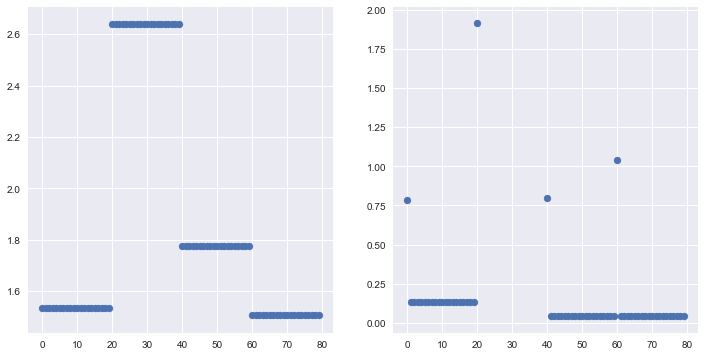

In [497]:
fnorms, loss_vals = eval_sequences(n_rotations=4)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(np.arange(len(fnorms)), fnorms);
plt.subplot(122)
plt.scatter(np.arange(len(loss_vals)), loss_vals);

### Rotating 2-D Images

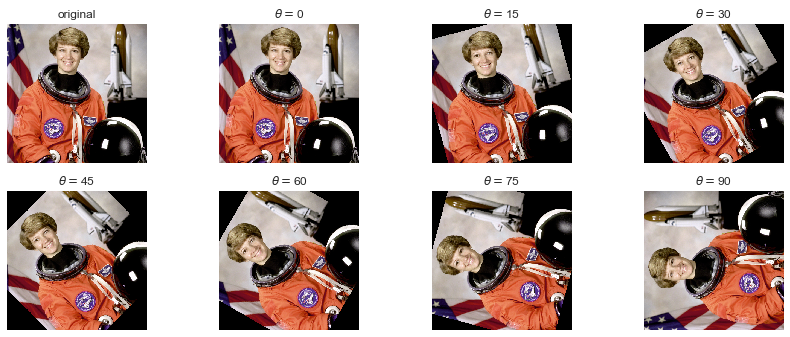

In [291]:
from skimage.transform import rotate

F = plt.figure(figsize=(12,5))
G = plt.GridSpec(2, 4, left=.01, right=.99, bottom=0.05, top=0.9, wspace=.01, hspace=0.2, figure=F)
ax = plt.subplot(G[0])
image = data.astronaut()
image_scaled = rescale(image, 0.25, anti_aliasing=True)

train_images = []
for i in range(7):
    train_images.append(rotate(image, angle=15*i, order=0))

ax.imshow(image)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('original')
for i in range(7):
    ax = plt.subplot(G[i+1])
    ax.imshow(train_images[i])
    ax.set_axis_off()
    ax.set_aspect('equal');
    ax.set_title(r'$\theta = $' + str(15*i));
plt.show();

### King's College Dataset
We have a variety of images described by a three dimensional position vector $p = [x, y, z]$ and a four dimensional orientation quaternion vector $q$ that represents rotations when normalized to unit length <br>

After training, the model takes a single RGB image and outputs the predicted camera position and orientation, which we refer to as the camera's pose (relative to a given scene). 

In [65]:
poses   = []
images  = []
my_path = 'data/KingsCollege'
fname = 'dataset_train.txt'
out_file = 'model_saved_weights'
# Processing Image Lables
with open(my_path + '/' + fname) as f:
    next(f)  # skip the 3 header lines
    next(f)
    next(f)
    for line in f:
        fname, p0, p1, p2, p3, p4, p5, p6 = line.split()
        p0 = float(p0)
        p1 = float(p1)
        p2 = float(p2)
        p3 = float(p3)
        p4 = float(p4)
        p5 = float(p5)
        p6 = float(p6)
        poses.append((p0, p1, p2, p3, p4, p5, p6))
        images.append(my_path + '/' + fname)

r = list(range(len(images)))
len(images)
images[0]
len(poses)
poses[0]
random.shuffle(r)
random.shuffle(r)
random.shuffle(r)

'Visual Landmark Dataset V1\n'

'ImageFile, Camera Position [X Y Z W P Q R]\n'

'\n'

1220

'data/KingsCollege/seq8/frame00064.png'

1220

(-9.123465, -13.208417, 1.722406, 0.683091, 0.543983, -0.314596, 0.372154)

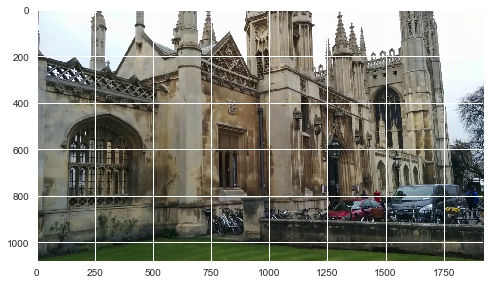

In [77]:
plt.imshow(plt.imread(images[1]));

In [32]:
SO3_GROUP = SpecialOrthogonalGroup(3)
writer = tf.python_io.TFRecordWriter(out_file)
hist_norm = False

# Tensorflow feature wrapper
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

for i in tqdm(r):

    pose_q = np.array(poses[i][3:7])
    pose_x = np.array(poses[i][0:3])

    rot_vec = SO3_GROUP.rotation_vector_from_quaternion(pose_q)[0]
    pose = np.concatenate((rot_vec, pose_x), axis=0)

    #logger.info('Processing Image: ' + images[i])
    X = imageio.imread(images[i])
    X = X[::4, ::4, :]
    if hist_norm:
        X = exposure.equalize_hist(X)

    img_raw = X.tostring()
    pose_raw = pose.astype('float32').tostring()
    pose_q_raw = pose_q.astype('float32').tostring()
    pose_x_raw = pose_x.astype('float32').tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(X.shape[0]),
        'width': _int64_feature(X.shape[1]),
        'channel': _int64_feature(X.shape[2]),
        'image': _bytes_feature(img_raw),
        'pose': _bytes_feature(pose_raw),
        'pose_q': _bytes_feature(pose_q_raw),
        'pose_x': _bytes_feature(pose_x_raw)}))

    writer.write(example.SerializeToString())

writer.close()
#logger.info('\n', 'Creating Dataset Success.')

100%|██████████████████████████████████████████████████████████████████████████████| 1220/1220 [03:22<00:00,  8.01it/s]


# References
___

**1.]** T. Liu, Z. Shi and Y. Liu, "Visualization of the Image Geometric Transformation Group Based on Riemannian Manifold," in IEEE Access, vol. 7, pp. 105531-105545, 2019. <br>
**2.]** D. Lin, E. Grimson, and J. Fisher, ‘‘Learning visual flows: A lie algebraic
approach,’’ in Proc. IEEE Conf. Comput. Vis. Pattern Recognit. (CVPR),
Jun. 2009, pp. 747–754<br>
**3.]** R. Arora. On learning rotations. In Y. Bengio, D. Schuurmans, J. Lafferty, C. K. I. Williams,
and A. Culotta, editors, Advances in Neural Information Processing Systems, volume 22, pages
55–63. MIT Press, 2009.